<a href="https://colab.research.google.com/github/Tbharvesh/DeepLearning/blob/main/RNN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Predicting Covid-19 Cases Using RNN GRU Model**

Workflow:


1.   Understanding the problem
2.   Collecting the data
3.   Data preprocessing
4.   Build Model using RNN & Grated Recurrent Unit (GRU)
5.   Training the dataset
6.   Predict


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt


from tensorflow.keras.layers import Dense, Dropout
from keras.layers import GRU
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [10]:
dataset = pd.read_csv("/complete.csv")

In [11]:
dataset.head()

,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered
0,2020-01-30,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
2,2020-02-01,Kerala,10.8505,76.2711,2.0,0,0.0,1,0,0
3,2020-02-02,Kerala,10.8505,76.2711,3.0,0,0.0,1,0,0
4,2020-02-03,Kerala,10.8505,76.2711,3.0,0,0.0,0,0,0


In [12]:
# Extracting date and total confirmed cases columns
date_column = 'Date'
confirmed_cases_column = 'Total Confirmed cases'

# Selecting only the columns of interest
main_dataset = dataset[[date_column, confirmed_cases_column]]

print(main_dataset)

            Date  Total Confirmed cases
0     2020-01-30                    1.0
1     2020-01-31                    1.0
2     2020-02-01                    2.0
3     2020-02-02                    3.0
4     2020-02-03                    3.0
...          ...                    ...
4687  2020-08-06                73050.0
4688  2020-08-06                 5725.0
4689  2020-08-06               104388.0
4690  2020-08-06                 8254.0
4691  2020-08-06                83800.0

[4692 rows x 2 columns]


In [13]:
main_dataset['Total Confirmed cases'] = main_dataset['Total Confirmed cases'].astype(int)

<ipython-input-13-799d83e423cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_dataset['Total Confirmed cases'] = main_dataset['Total Confirmed cases'].astype(int)


In [14]:
# Timeseries componeent is Date ,therefore it is considered as index here --> which is used to locate any column
main_dataset = main_dataset.rename(columns={'Total Confirmed cases': 'Cases'})

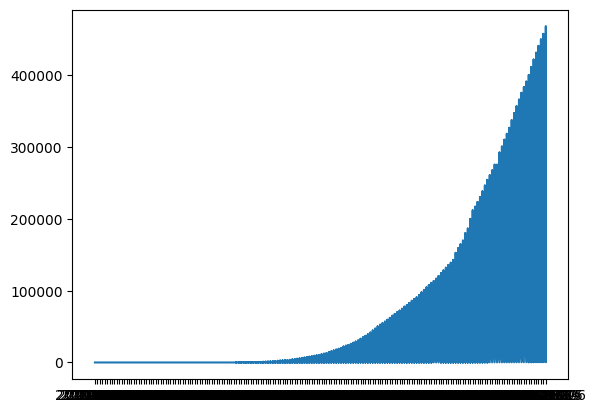

In [15]:
plt.plot(main_dataset.Date,main_dataset.Cases)
plt.show()


##3. Data Preprocessing

We use following steps to preprocess the available dataset.



1.   Create new features from the available variables
2.   Create target and predictor datasets
3.   Scale the values in the datasets
4.   Get the datasets into desired format and shape.
5.   Split the dataset into train & test with appropriate ratio.



At every point we are taking moving avg


Moving avg= (sum of all the items till n)/n

Exponential moving avg = with every val a factor is multiplied -->If we are at kth instance the value at k-1 is most impotant other than the previous data

Create a new variable called Exponential Moving Average(EMA). EMA gives more weightage to the recent values rather than the old values. This could be handy in time series forecasting techniques.

We will take exponential moving average for 3 days in our example.

Note: You can create any number of such variables and any days.
Exponential moving avg is calculated as:

1.5*0.5 + 3*0.5 =2.25

2.25*0.5 + 3*0.5 = 2.62

In [16]:
dataset = main_dataset #Create another dataset same as the main dataset. Just to avoid replacing the main one.
dataset = dataset.set_index('Date') #Set the index of the dataset as the date
dataset = dataset['Cases'] #We will be left with only one column Cases for our dataset

In [17]:
dataset=dataset.to_frame() #Convert the Series into a dataframe object
dataset['Cases_MA2']=dataset.expanding(min_periods=3).mean()  #min_periods is used to set the no. of periods for calculating MA. Mean is for calculating average.

In [18]:
dataset['EMA'] = dataset.iloc[:,0].ewm(span=3,adjust=False).mean() #ewm is used exponential moving average

In [20]:
dataset = dataset[dataset['Cases_MA2'].notna()] #Remove the rows that have NAs
dataset.head()


,Cases,Cases_MA2,EMA
Date,,,
2020-02-01,2,1.333333,1.50000
2020-02-02,3,1.750000,2.25000
2020-02-03,3,2.000000,2.62500
2020-02-04,3,2.166667,2.81250
2020-02-05,3,2.285714,2.90625


In [21]:
#Cases is the column we have to predict.
target=dataset[['Cases']]
del dataset['Cases']

In [22]:
x, y = dataset.values, target.values

In [23]:
x_scaled_set = MinMaxScaler() #Use MinMaxScaler function from sklearn.preprocessing library
y_scaled_set = MinMaxScaler()

X = x_scaled_set.fit_transform(x) #Fit to data and transform the data array x
Y = y_scaled_set.fit_transform(y.reshape(-1,1)) #Fit to data and transform the data array y. Reshape the y variable to long format

In [24]:
X_train_data=X[0:4000,]
y_train_data=Y[0:4000,]
X_test_data=X[4000:4690,]
y_test_data=Y[4000:4690,]

In [25]:
X_train_data = X_train_data.reshape((-1,1,2)) #we are processing one row two cols at a time
X_test_data = X_test_data.reshape((-1,1,2))

## 4. Build Model using RNN & Grated Recurrent Unit (GRU)

We will use the Sequential class from keras.models library to define a linear stack of network layers. These form a model.

Using the add method, the necessary layers would be added to the model.

RNNs have an issue of short-term memory which means if the sequence is long, they tend to leave leave out the earlier ones and only retain information related to the later ones. To remove this problem, GRUs are used. In a way, GRU helps in keeping only the important information in the whole sequence. Initially, we add the GRU layer with necessary parameters.

Then, we add a Dropout layer to prevent overfitting of the model.

We add another set of GRU and Dropout layers.

Post which we add a Dense layer which gives us the fully connected layer. We use the regular sigmoid activation function.

In our model, we will use Adam optimizer and consider mean square error as our loss function since ours is a Regression model.

In [29]:
GRU_model = Sequential() #Use Sequential function from keras.model library
GRU_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(1, 2))) #Add GRU model with 512 units. Note that return sequences should be true to pass on the sequences. Ensure that input_shape is inline with the inout data.
GRU_model.add(Dropout(0.2)) #Add a dropout layer to avoid overfitting.
GRU_model.add(GRU(units=256)) #Add another GRU layer with 256 units.
GRU_model.add(Dropout(0.2)) #Add another dropout layer to avoid overfitting.
GRU_model.add(Dense(1, activation='relu')) #Finally, add a dense layer for getting a fully connected layer.
# Cannot use sigmoid-bec used only for binary classification


In [30]:
GRU_model.compile(loss='mse', optimizer='adam', metrics = ['accuracy']) #mse is mean square error which is the loss function and Adam optimizer will be the ooptimizer.

## 5. Training the Dataset

Fit the model by passing the training data we created earlier along with relevant batch size, epochs, validation split.

Batch Size - The batch size controls the number of training samples before the model's internal parameters are updated

Epochs - How many times the whole training dataset be passed through the network.

In [31]:
GRU_model.fit(X_train_data,y_train_data,batch_size=250, epochs=100, validation_split=0.15, verbose=1)
#GRU_model.save("covid_GRU.h5") #Save the model if you want for reuse.

Epoch 1/100
14/14 [==============================] - 7s 164ms/step - loss: 6.9230e-04 - accuracy: 0.0800 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 1s 73ms/step - loss: 6.6731e-04 - accuracy: 0.0800 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 1s 74ms/step - loss: 6.6731e-04 - accuracy: 0.0800 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 1s 73ms/step - loss: 6.6731e-04 - accuracy: 0.0800 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 5/100
14/14 [==============================] - 1s 74ms/step - loss: 6.6731e-04 - accuracy: 0.0800 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 1s 73ms/step - loss: 6.6731e-04 - accuracy: 0.0800 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 1s 72ms/step - loss: 6.6731e-04 - accuracy: 0.


## 6.Predict

Use evaluate function to get the loss metric. Apply the created model on test dataset.

Plot the predicted and actual values on a graph.

The lower the 'score' metric (ie mean square error), better is our model.

In [32]:
score = GRU_model.evaluate(X_test_data, y_test_data) #Evaluate model can be used to get the loss metric.
print('Score: {}'.format(score))
y_pred = GRU_model.predict(X_test_data) #Apply the built model on test data.
# Inverse transform mation done otherwise accuracy will be in the invered term
y_test_pred = y_scaled_set.inverse_transform(y_pred) #Use inverse transform to undo the scaling that was done before. This gives us the original values.
y_test_actual = y_scaled_set.inverse_transform(y_test_data) # Apply the inverse transform on the actual dataset for easy comparison of predicted vs actual.
#plt.plot(y_test_pred[-100:], label='Predicted') #Plot the predicted vs actual graph
#plt.plot(y_test_actual[-100:], label='Actual')
#plt.legend()
#plt.show()

22/22 [==============================] - 0s 15ms/step - loss: 0.0343 - accuracy: 0.0000e+00
Score: [0.03429338335990906, 0.0]
22/22 [==============================] - 3s 11ms/step


In [33]:
# x_test-->inputr-->y_pred (output) -->check with y_test values
# Due to transformation while processing
test_Dates=main_dataset.Date[4000:4690] #create an object which has the dates for the Test data.

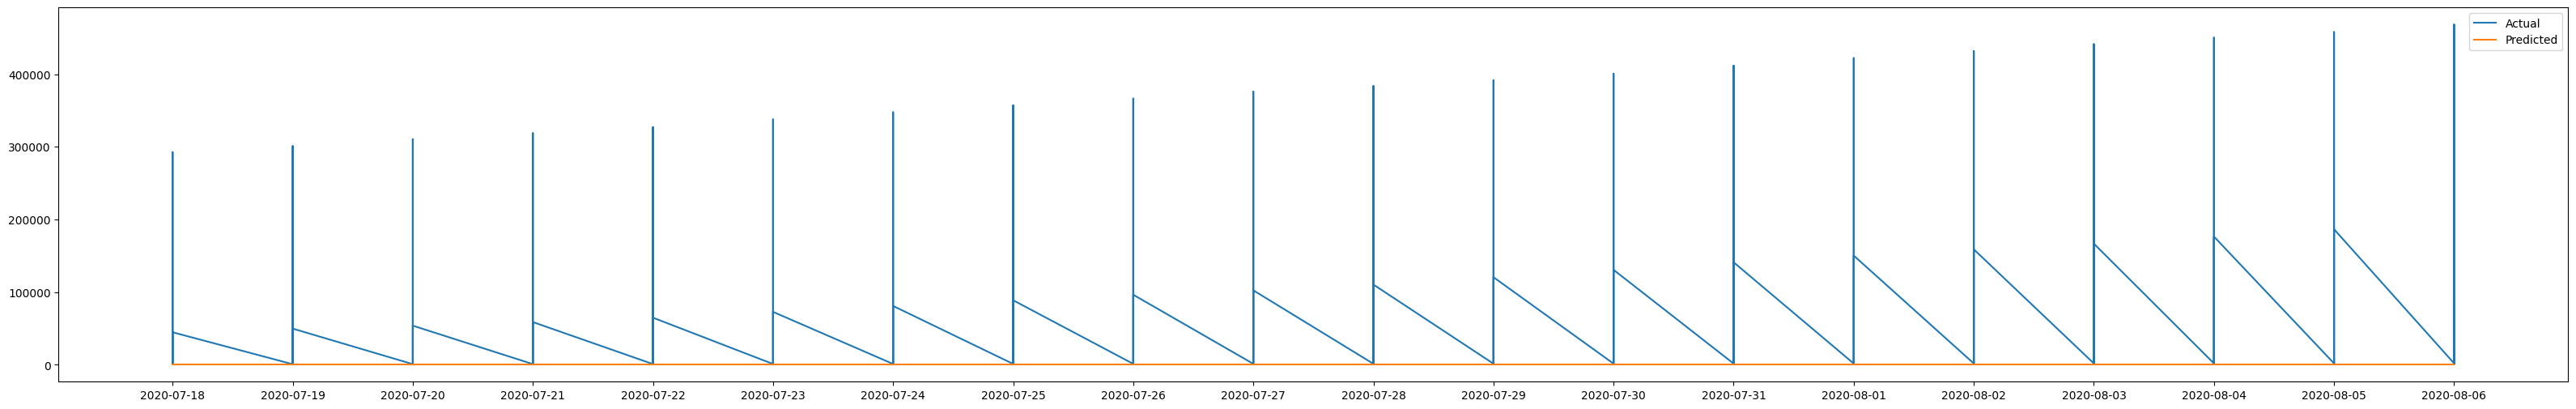

In [34]:


# Define the figure size
fig_size = (40, 6)  # Adjust width and height as needed

# Create a new figure with the specified size
plt.figure(figsize=fig_size)

# Assuming test_Dates, y_test_actual, and y_test_pred are already defined

# Plot actual and predicted data
plt.plot(test_Dates, y_test_actual[-690:], label='Actual')
plt.plot(test_Dates, y_test_pred[-690:], label='Predicted')

# Add legend
plt.legend()

# Show the plot
plt.show()